In [42]:
from sklearn.metrics import f1_score
import scipy.sparse as sp
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle
import matplotlib.pyplot as plt



from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [43]:
rand_state = 51
batch = 100

X, y = fetch_20newsgroups_vectorized('all', return_X_y=True, normalize=True)

C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass subset=all as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_state, stratify=y, test_size=0.1)


In [45]:
X_train_rest, X_train_initial, y_train_rest, y_train_initial = train_test_split(X_train, y_train, random_state=rand_state, stratify=y_train, test_size=0.025/0.9)


In [46]:
def active_training_similarity(X_init, y_init, X_rest, y_rest, model, sim_array_init, batch_size=100):
    scores = []
    train_size = []

    np.set_printoptions(threshold=100)

    model.fit(X_init, y_init)
    y_pred = model.predict(X_test)

    scores.append(f1_score(y_test, y_pred, average='weighted'))
    train_size.append(X_init.shape[0])
    count = 0
    
    for i in range(20):
    #while X_rest.shape[0] > 0:
        #print(sim_array_init)
        
        similarities = [(cosine_similarity(X_rest.getrow(i).toarray(), np.reshape(sim_array_init, (-1,len(sim_array_init))))[0][0], i) for i in range(X_rest.shape[0])]

        similarities.sort(key=lambda x: x[0], reverse=True)

        #print(similarities)

        size = batch_size if X_rest.shape[0] >= batch_size else X_rest.shape[0]
        #cut_list = list(range(size))

        cut_list = [x[1] for x in similarities[0:size]]

        cut_set = set(cut_list)

        #rest_list = list(range(size, X_rest.shape[0]))

        rest_list = list(range(X_rest.shape[0]))

        rest_list = [x for x in rest_list if x not in cut_set]

        add_x = X_rest[cut_list, :]

        add_sim = np.mean(add_x.toarray(), axis=0)

        #add_sum = np.sum(add_x.toarray(), axis=0)
        #add_sim = add_sum / np.sqrt(np.sum(add_sum ** 2))

        stack_sim_arr = np.stack((sim_array_init, add_sim))

        sim_array_init = np.average(stack_sim_arr, axis=0, weights=[X_init.shape[0], add_x.shape[0]])

        #sim_array_init = sim_array_init / np.sqrt(np.sum(sim_array_init ** 2)) #extra

        #add_y = y_rest[0:size]
        add_y = [y_rest[i] for i in cut_list]
        X_rest = X_rest[rest_list, :]
        #y_rest = y_rest[size:]
        y_rest = [y_rest[i] for i in rest_list]
        X_init = sp.vstack((X_init, add_x))
        y_init = np.concatenate((y_init, add_y))

        model.fit(X_init, y_init)
        y_pred = model.predict(X_test)


        scores.append(f1_score(y_test, y_pred, average='weighted'))
        train_size.append(X_init.shape[0])
        print(train_size)
        print("iterasyon: "+ str(count+1) + " " + " basarim : "+ str(scores[count]))
        count += 1
    return scores, train_size

def active_training(X_init, y_init, X_rest, y_rest, model, batch_size=100):
    scores = []
    train_size = []

    model.fit(X_init, y_init)
    y_pred = model.predict(X_test)

    scores.append(f1_score(y_test, y_pred, average='weighted'))
    train_size.append(X_init.shape[0])
    count = 0
    
    for i in range(20):
    #while X_rest.shape[0] > 0:

        probs = model.predict_proba(X_rest)

        entropies = [(entropy(x), i) for i, x in enumerate(probs)]


        size = batch_size if X_rest.shape[0] >= batch_size else X_rest.shape[0]
        #cut_list = list(range(size))

        cut_list = [x[1] for x in entropies[0:size]]

        cut_set = set(cut_list)

        #rest_list = list(range(size, X_rest.shape[0]))

        rest_list = list(range(X_rest.shape[0]))

        rest_list = [x for x in rest_list if x not in cut_set]

        add_x = X_rest[cut_list, :]
        #add_y = y_rest[0:size]
        add_y = [y_rest[i] for i in cut_list]
        X_rest = X_rest[rest_list, :]
        #y_rest = y_rest[size:]
        y_rest = [y_rest[i] for i in rest_list]
        X_init = sp.vstack((X_init, add_x))
        y_init = np.concatenate((y_init, add_y))

        model.fit(X_init, y_init)
        y_pred = model.predict(X_test)


        scores.append(f1_score(y_test, y_pred, average='weighted'))
        train_size.append(X_init.shape[0])
        print(train_size)
        print("iterasyon: "+ str(count+1) + " " + " basarim : "+ str(scores[count]))
        count += 1
    return scores, train_size


def standard_training(X_init, y_init, X_rest, y_rest, model, batch_size=100):
    #select

    scores = []
    train_size = []

    model.fit(X_init, y_init)
    y_pred = model.predict(X_test)

    scores.append(f1_score(y_test, y_pred, average='weighted'))
    train_size.append(X_init.shape[0])
    count=0
    
    for i in range(20):
    #while X_rest.shape[0] > 0:
        size = batch_size if X_rest.shape[0] >= batch_size else X_rest.shape[0]
        cut_list = list(range(size))
        rest_list = list(range(size, X_rest.shape[0]))
        add_x = X_rest[cut_list,:]
        add_y = y_rest[0:size]
        X_rest = X_rest[rest_list,:]
        y_rest = y_rest[size:]
        X_init = sp.vstack((X_init, add_x))
        y_init = np.concatenate((y_init, add_y))

        model.fit(X_init, y_init)
        y_pred = model.predict(X_test)

        scores.append(f1_score(y_test, y_pred, average='weighted'))
        train_size.append(X_init.shape[0])
        print(train_size)
        print("iterasyon: "+ str(count+1) + " " + " basarim : "+ str(scores[count]))
        count += 1

    return scores, train_size










In [47]:
lr = LogisticRegression(solver='sag',
                                multi_class='multinomial',
                                penalty='l2',
                                tol=0.005,
                                max_iter=10,
                                random_state=42,
                                C=5,
                                warm_start=True
                                )

In [48]:
## cosine similiarity - eren

sum_arr = np.sum(X_train_initial.toarray(), axis=0)
sim_arr = sum_arr / np.sqrt(np.sum(sum_arr**2))


result = active_training_similarity(X_train_initial, y_train_initial, X_train_rest, y_train_rest, lr, sim_arr, batch_size=batch)

with open('active_dissim' + str(rand_state) + '_' + str(batch) + '.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(result, f)

C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572]
iterasyon: 1  basarim : 0.4244019996026788


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672]
iterasyon: 2  basarim : 0.4534232249802753


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772]
iterasyon: 3  basarim : 0.45702074095331996


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872]
iterasyon: 4  basarim : 0.46727947803173603


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972]
iterasyon: 5  basarim : 0.49326608466415894


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072]
iterasyon: 6  basarim : 0.5053620883893288


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172]
iterasyon: 7  basarim : 0.513951515039349


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272]
iterasyon: 8  basarim : 0.5283813230194303


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372]
iterasyon: 9  basarim : 0.5419418090030392


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472]
iterasyon: 10  basarim : 0.5507706747675928


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572]
iterasyon: 11  basarim : 0.5575094570637769


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672]
iterasyon: 12  basarim : 0.564925476531799


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672, 1772]
iterasyon: 13  basarim : 0.5696481328156809


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672, 1772, 1872]
iterasyon: 14  basarim : 0.5889073130508227


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672, 1772, 1872, 1972]
iterasyon: 15  basarim : 0.5921834036102768


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672, 1772, 1872, 1972, 2072]
iterasyon: 16  basarim : 0.6076964813352478


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672, 1772, 1872, 1972, 2072, 2172]
iterasyon: 17  basarim : 0.621365782203632


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672, 1772, 1872, 1972, 2072, 2172, 2272]
iterasyon: 18  basarim : 0.6273764461259325


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672, 1772, 1872, 1972, 2072, 2172, 2272, 2372]
iterasyon: 19  basarim : 0.6359786731735569
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672, 1772, 1872, 1972, 2072, 2172, 2272, 2372, 2472]
iterasyon: 20  basarim : 0.6375838849790021


C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [49]:
###^result shows up after training completed time compx: 26dk 22sn

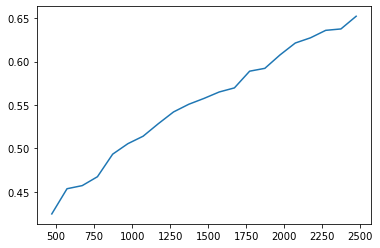

In [50]:
plt.plot(result[1], result[0])


In [51]:
def unk(probs):
    unc=1 - probs.max(axis=1)
    return unc


# unk_samp= unk(probs)
# indices = np.argsort(unk_samp)[::-1]
# unk_samp[indices[0]]

In [52]:
# enum_unc.sort(key=lambda x: x[0], reverse=True)


In [53]:
# uncertainlerden maxini al

In [54]:
def active_training_unc(X_init, y_init, X_rest, y_rest, model, batch_size=100):
    scores = []
    train_size = []

    model.fit(X_init, y_init)
    y_pred = model.predict(X_test)

    scores.append(f1_score(y_test, y_pred, average='weighted'))
    train_size.append(X_init.shape[0])
    count=0
    
    for i in range(20):
    #while X_rest.shape[0] > 0:

        probs = model.predict_proba(X_rest)

        unk_samp= unk(probs)
        indices = np.argsort(unk_samp)[::-1]
        unk_samp[indices[0]]
        enum_unc=[]
        for i,x in enumerate(unk_samp):
        #print(i,x)
            enum_unc.append((x, i))
        
        enum_unc.sort(key=lambda x: x[0], reverse=True)


        size = batch_size if X_rest.shape[0] >= batch_size else X_rest.shape[0]
        #cut_list = list(range(size))

        cut_list = [x[1] for x in enum_unc[0:size]]

        cut_set = set(cut_list)

        #rest_list = list(range(size, X_rest.shape[0]))

        rest_list = list(range(X_rest.shape[0]))

        rest_list = [x for x in rest_list if x not in cut_set]

        add_x = X_rest[cut_list, :]
        #add_y = y_rest[0:size]
        add_y = [y_rest[i] for i in cut_list]
        X_rest = X_rest[rest_list, :]
        #y_rest = y_rest[size:]
        y_rest = [y_rest[i] for i in rest_list]
        X_init = sp.vstack((X_init, add_x))
        y_init = np.concatenate((y_init, add_y))

        lr.fit(X_init, y_init)
        y_pred = lr.predict(X_test)


        scores.append(f1_score(y_test, y_pred, average='weighted'))
        train_size.append(X_init.shape[0])

        print(train_size)
        print("iterasyon: "+ str(count+1) + " " + " basarim : "+ str(scores[count]))
        count += 1
        
    return scores, train_size


In [60]:
### uncertainty sampling - eren
# 
batch=100

result2 = active_training_unc(X_train_initial, y_train_initial, X_train_rest, y_train_rest, lr,batch_size=batch)

with open('active_dissim' + str(rand_state) + '_' + str(batch) + '.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(result, f)

C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[472, 572]
iterasyon: 1  basarim : 0.651257384872417
[472, 572, 672]
iterasyon: 2  basarim : 0.625492119796535
[472, 572, 672, 772]
iterasyon: 3  basarim : 0.6254717018764164
[472, 572, 672, 772, 872]
iterasyon: 4  basarim : 0.6442086063065702
[472, 572, 672, 772, 872, 972]
iterasyon: 5  basarim : 0.6601236244057682
[472, 572, 672, 772, 872, 972, 1072]
iterasyon: 6  basarim : 0.6709171712069837
[472, 572, 672, 772, 872, 972, 1072, 1172]
iterasyon: 7  basarim : 0.6869516469277599
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272]
iterasyon: 8  basarim : 0.7026524749362899
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372]
iterasyon: 9  basarim : 0.7273623721814658
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472]
iterasyon: 10  basarim : 0.7365696932128725
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572]
iterasyon: 11  basarim : 0.750512424311385
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672]
iterasyon: 12  basarim : 0.74975351042

# Results of unc

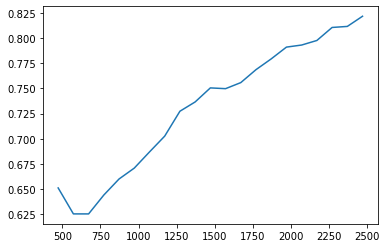

In [61]:
 plt.plot(result2[1], result2[0])   ##time complexiti : 16.2 sn

In [62]:
##random sampling -can
X, y = fetch_20newsgroups_vectorized('all', return_X_y=True, normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_state, stratify=y, test_size=0.1)
X_train_rest, X_train_initial, y_train_rest, y_train_initial = train_test_split(X_train, y_train, random_state=rand_state, stratify=y_train, test_size=0.025/0.9)

lr = LogisticRegression(solver='sag',
                                multi_class='multinomial',
                                penalty='l2',
                                tol=0.005,
                                max_iter=50,
                                random_state=42,
                                C=2,
                                warm_start=True
                                )


result3 = standard_training(X_train_initial, y_train_initial, X_train_rest, y_train_rest, lr, batch_size=batch)

with open('standard_' + str(rand_state) + '_' + str(batch) + '.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(result, f)

C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass subset=all as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[472, 572]
iterasyon: 1  basarim : 0.37278756424150394
[472, 572, 672]
iterasyon: 2  basarim : 0.41255980067915354
[472, 572, 672, 772]
iterasyon: 3  basarim : 0.42751348692337454
[472, 572, 672, 772, 872]
iterasyon: 4  basarim : 0.44978970172986865
[472, 572, 672, 772, 872, 972]
iterasyon: 5  basarim : 0.48662030396372774
[472, 572, 672, 772, 872, 972, 1072]
iterasyon: 6  basarim : 0.49904283295119495
[472, 572, 672, 772, 872, 972, 1072, 1172]
iterasyon: 7  basarim : 0.5024042060093933
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272]
iterasyon: 8  basarim : 0.5201703576325117
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372]
iterasyon: 9  basarim : 0.5357451025572474
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472]
iterasyon: 10  basarim : 0.5447169444977595
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572]
iterasyon: 11  basarim : 0.5696131336373889
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672]
iterasyon: 12  basarim : 0.59

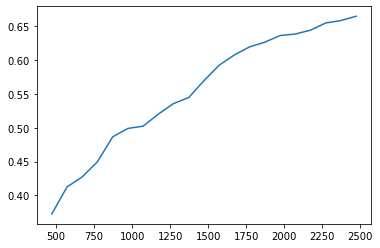

In [63]:
plt.plot(result3[1], result3[0]) ##time complexity 13.4 sn

In [64]:
## entropy sampling - can 
X, y = fetch_20newsgroups_vectorized('all', return_X_y=True, normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_state, stratify=y, test_size=0.1)
X_train_rest, X_train_initial, y_train_rest, y_train_initial = train_test_split(X_train, y_train, random_state=rand_state, stratify=y_train, test_size=0.025/0.9)

lr = LogisticRegression(solver='sag',
                                multi_class='multinomial',
                                penalty='l2',
                                tol=0.005,
                                max_iter=50,
                                random_state=42,
                                C=100,
                                warm_start=True
                                )


result4 = active_training(X_train_initial, y_train_initial, X_train_rest, y_train_rest, lr, batch_size=batch)

with open('active_' + str(rand_state) + '_' + str(batch) + '.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(result, f)


#sim_arr = np.mean(X_train_initial.toarray(), axis=0) 

C:\Users\hakki.arkangil\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass subset=all as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[472, 572]
iterasyon: 1  basarim : 0.47689045379291634
[472, 572, 672]
iterasyon: 2  basarim : 0.5173915029457109
[472, 572, 672, 772]
iterasyon: 3  basarim : 0.5365736624007621
[472, 572, 672, 772, 872]
iterasyon: 4  basarim : 0.5762413504482103
[472, 572, 672, 772, 872, 972]
iterasyon: 5  basarim : 0.5999732055000183
[472, 572, 672, 772, 872, 972, 1072]
iterasyon: 6  basarim : 0.6296517170770004
[472, 572, 672, 772, 872, 972, 1072, 1172]
iterasyon: 7  basarim : 0.6393521928246684
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272]
iterasyon: 8  basarim : 0.6567319095524733
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372]
iterasyon: 9  basarim : 0.6704994467894874
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472]
iterasyon: 10  basarim : 0.6921637183123249
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572]
iterasyon: 11  basarim : 0.6985861790149526
[472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572, 1672]
iterasyon: 12  basarim : 0.7171038

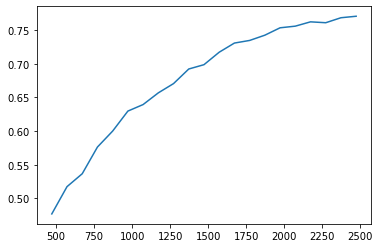

In [65]:
plt.plot(result4[1], result4[0]) #time complexity 23.4 sn

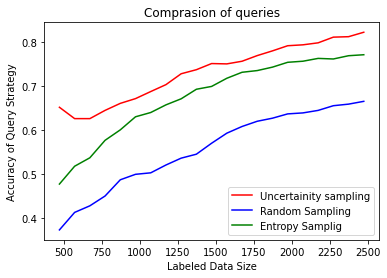

In [74]:
plt.plot(result2[1], result2[0], 'r',label="Uncertainity sampling") # plotting t, a separately 
plt.plot(result3[1], result3[0], 'b',label="Random Sampling") # plotting t, b separately 
plt.plot(result4[1], result4[0], 'g',label="Entropy Samplig") # plotting t, c separately 
plt.title("Comprasion of queries")
plt.ylabel("Accuracy of Query Strategy")
plt.xlabel("Labeled Data Size")
plt.legend(loc='best')
plt.show()
